In [1]:
!pip install tweepy

In [2]:
import tweepy
import pandas as pd
import csv
from google.colab import drive

In [3]:
consumer_key ='YOUR_CREDENTIALS'
consumer_secret ='YOUR_CREDENTIALS'
access_token_key ='YOUR_CREDENTIALS'
access_token_secret='YOUR_CREDENTIALS'

In [4]:
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [5]:
#Estableciendo conexión
def api_connection():
  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_token_key,access_token_secret)
  api = tweepy.API(auth, wait_on_rate_limit=True)

  try:
    api.verify_credentials()
    print('Auth OK!')
  except Exception:
    print('Error!')

  return api

api = api_connection()

Auth OK!


In [6]:
def extract_tweets(hashtag, count):
  api = api_connection()
  tweets = []
  for tweet in tweepy.Cursor(api.search, q=hashtag, lang='es', include_rts=False).items(count):
    if (not tweet.retweeted and 'RT @' not in tweet.text):
      tweets.append(tweet.text)
      #Podemos traer avatar, localización, verificada, hashtag, user_name, user_id
  return tweets


In [7]:
print('DS Álvaro Uribe Vélez')
tweets = extract_tweets('#AlvaroUribe', 50)
df = pd.DataFrame(data=tweets, columns=['text'])
path = f'drive/My Drive/Colab Notebooks/Project/Tweepy/tweets.csv'
tweets_text = df.to_csv(path,sep=',', index=False)
tweets_text

DS Álvaro Uribe Vélez
Auth OK!


In [8]:
df = pd.read_csv(path)

In [9]:
df.head(10)

,text
0,"#ATENCIÓN, Otra investigación contra abogado #..."
1,Uribe es la tóxica que cuando la atrapan dice ...
2,#ÁlvaroUribe con orden de arresto y con Covid-...
3,Hay tienen al #Malayaga \nEn fotografía con el...
4,@NoticiasCaracol Algo se trama el señor #Alvar...
5,Esto escribía #IvanDuque d #AlvaroUribe antes ...
6,#opinión | La libertad de Álvaro Uribe Vélez @...
7,#Colombia: el oficialismo ataca a la Corte Sup...
8,¿Cree usted que el ex mandatario podrá superar...
9,Ah que tiene un parecido a alguien que también...


In [10]:
import nltk 
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
def transform(text):
  stopWords = set(stopwords.words('spanish'))
  text = str(text)
  text = re.sub(r'@[A-Za-z0-9]+',' ', text) # Remover menciones @AlvaroUribeVel
  text = re.sub(r'RT[\s]', ' ', text) # Remover RTs
  text = re.sub(r'#',' ', text)# Remover hashtag en el tweet
  text = re.sub(r'https?:\/\/\S+', ' ', text) #Remover links

  words = text.lower().split()

  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  stripped = [re_punc.sub('', w) for w in words]
  no_garbage = [w for w in stripped if not w in stopWords]

  return(" ".join(no_garbage))

In [12]:
df['tweets_transform'] = df['text'].apply(transform)

In [13]:
df['tweets_transform'].head()

0    atención investigación abogado diegocadena ord...
1    uribe tóxica atrapan dice embarazada puede usa...
2    álvarouribe orden arresto covid19 ¿aislamiento...
3    malayaga fotografía ahora convicto alvarouribe...
4       trama señor alvarouribe colombia covid19 virus
Name: tweets_transform, dtype: object

## Analysis sentiment

In [14]:
from textblob import TextBlob

def set_Sentiment(text):
  text = str(text)
  if text != '':
    analysis = TextBlob(text)
    if analysis.detect_language() == 'es':
      analysis = analysis.translate(from_lang ='es', to='en').sentiment
      sentiment = analysis.polarity
      return sentiment

In [15]:
df['polarity'] = df['tweets_transform'].apply(set_Sentiment)

In [16]:
#-1 más negatividad, 1 más positiva

df['polarity'].head(10)

0   -0.400000
1    0.094444
2   -0.050000
3    0.000000
4    0.000000
5    0.000000
6    0.000000
7    0.000000
8    0.250000
9    0.300000
Name: polarity, dtype: float64

In [17]:
#guardar polarity 
path = f'drive/My Drive/Colab Notebooks/Project/Tweepy/tweets_polarity.csv'
tweets_polarity = df['polarity'].to_csv(path, index=False)
tweets_polarity


In [18]:
#Mostrando contenido
%cd 'drive/My Drive/Colab Notebooks/Project/Tweepy'
%ls

/content/drive/My Drive/Colab Notebooks/Project/Tweepy
tweets.csv  tweets_polarity.csv


In [19]:
tweets_text = pd.read_csv('tweets.csv')
tweets_polarity = pd.read_csv('tweets_polarity.csv')

# Concatenando Tweets con su respectiva polaridad
join_datasets = pd.concat([tweets_text,tweets_polarity], axis=1)


## Tweets con su respectiva polaridad

In [20]:
join_datasets

,text,polarity
0,"#ATENCIÓN, Otra investigación contra abogado #...",-0.400000
1,Uribe es la tóxica que cuando la atrapan dice ...,0.094444
2,#ÁlvaroUribe con orden de arresto y con Covid-...,-0.050000
3,Hay tienen al #Malayaga \nEn fotografía con el...,0.000000
4,@NoticiasCaracol Algo se trama el señor #Alvar...,0.000000
5,Esto escribía #IvanDuque d #AlvaroUribe antes ...,0.000000
6,#opinión | La libertad de Álvaro Uribe Vélez @...,0.000000
7,#Colombia: el oficialismo ataca a la Corte Sup...,0.000000
8,¿Cree usted que el ex mandatario podrá superar...,0.250000
9,Ah que tiene un parecido a alguien que también...,0.300000


In [21]:
#Guardando resultado
result = join_datasets.to_csv('result.csv', index=False)
result

WordCloud

In [22]:
from wordcloud import WordCloud

text = df.tweets_transform
text.head()

0    atención investigación abogado diegocadena ord...
1    uribe tóxica atrapan dice embarazada puede usa...
2    álvarouribe orden arresto covid19 ¿aislamiento...
3    malayaga fotografía ahora convicto alvarouribe...
4       trama señor alvarouribe colombia covid19 virus
Name: tweets_transform, dtype: object

In [23]:
text = ' '.join(df.tweets_transform)
text

'atención investigación abogado diegocadena ordena corte suprema defensor penalista… uribe tóxica atrapan dice embarazada puede usar misma excusa… álvarouribe orden arresto covid19 ¿aislamiento encarcelamiento ¿quién da malayaga fotografía ahora convicto alvarouribe pues  trama señor alvarouribe colombia covid19 virus escribía ivanduque d alvarouribe q convirtiera mentor politico 1982 ivan duque escobar pa… opinión  libertad álvaro uribe vélez colombia uribe alvarouribe colombia oficialismo ataca corte suprema pretende reformar constitución defender álvarouribe… ¿cree usted ex mandatario podrá superar covid19 cuenta paciente asintomático… ah parecido alguien fué poderoso matarife pabloescobar alvarouribe… celebro último caso covid colombia alvarouribe acabó pandemia ocupación las… internacionales  ex presidente álvarouribe da positivo covid19 detalles deberian preguntarle ivanduque papá denunció alvarouribe lideraba aerocivil alvarouribe muestra socialismo perdona coexiste prontamente 

In [24]:
wordcloud = WordCloud(width=1024, height=800, background_color='white', min_font_size=14).generate(text)

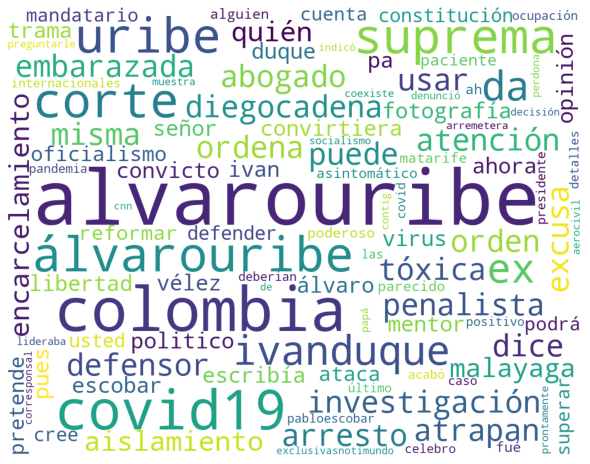

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('Wordcloud.jpg')
plt.tight_layout(pad=0)
plt.show()